<a id='sect0'></a>
## <font color='darkblue'>Table of Contents</font>
([article source](https://www.kaggle.com/jaysueno/titanic-comp))
1. <font size='3ptx'>[**Overview**](#sect1)</font>
2. <font size='3ptx'>[**System Setup**](#sect2)</font>
3. <font size='3ptx'>[**Exploratory Data Analysis**](#sect3)</font>
4. <font size='3ptx'>[**Preprocessing**](#sect4)</font>
5. <font size='3ptx'>[**Training Models**](#sect5)</font>
6. <font size='3ptx'>[**Evaluate -> Tune -> Ensemble**](#sect6)</font>
7. <font size='3ptx'>[**Conclusion**](#sect7)</font>

<a id='sect1'></font>
## <font color='darkblue'>1. Overview</font>

<a id='sect1'></a>
### <font color='darkgreen'>The Challenge</font>
([Back](#sect0)) <font size='3ptx'>**The sinking of the Titanic is one of the most infamous shipwrecks in history.**</font>

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In [**this challenge**](https://www.kaggle.com/c/titanic/overview), we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (<font color='brown'>ie name, age, gender, socio-economic class, etc</font>).

### <font color='darkgreen'>Goal</font>
It is your job to predict if a passenger survived the sinking of the Titanic or not. For each in the test set, you must predict a 0 or 1 value for the variable.

Metric **Your score is the percentage of passengers you correctly predict. This is known as accuracy.**

**Submission File Format You should submit a csv file with exactly 418 entries plus a header row**. Your submission will show an error if you have extra columns (<font color='brown'>beyond PassengerId and Survived</font>) or rows.

The file should have exactly 2 columns:
* **PassengerId** (sorted in any order)
* **Survived** (contains your binary predictions: 1 for survived, 0 for deceased)
```csv
PassengerId,Survived
892,0
893,1
894,0
Etc.
```

<a id='sect2'></a>
## <font color='darkblue'>2. Setup System Environment</font>
([Back](#sect0)) We import the necessary packages below:

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname
sys.path.append(os.environ.get('KUTILS_ANALYSIS_ROOT', 'C:\John\Personal\Github\kutils_analysis'))

In [2]:
from kutils.analysis import histplot, barplot, boxplot, fiplot, corr
%matplotlib inline

From [**here**](https://www.kaggle.com/c/titanic/data), you can download the necessary files for training/testing data. The data has been split into two groups:
* **training set** (<font color='olive'>train.csv</font>): The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.
* **test set** (<font color='olive'>test.csv</font>): The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include **<font color='olive'>gender_submission.csv</font>**, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like. Below are column definition:

|Variable | Definition | Key |
| --- | --- | --- |
|survival | Survival   | 0 = No, 1 = Yes| 
|pclass	  | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|sex	| Sex | |	
|Age	| Age | in years	|
|sibsp	| # of siblings / spouses aboard the Titanic	| |
|parch	|# of parents / children aboard the Titanic	||
|ticket	|Ticket number	||
|fare	|Passenger fare	||
|cabin	|Cabin number	||
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

<a id='sect3'></a>
## <font color='darkblue'>3. Exploratory Data Analysis</font>
([Back](#sect0)) <font size='3ptx'>**Conduct below analysis to look for more features:**</font>
* <font size='3ptx'>[**Feature Analysis**](#feature_analysis)</font>    
    * [**raw data info**](#raw_data_info)
    * [**raw data distribution**](#raw_data_distribution)
    * [**correlation with `Survived`**](#correlation)
    * [**`Embarked` analysis**](#embarked_analysis)
    * [**binning of `Age`**](#binning_age)
    * [**binning of `Fare`**](#binning_fare)
* <font size='3ptx'>[**Outliers Analysis**](#outlier_analysis)</font>
* <font size='3ptx'>[**`Name` Analysis**](#name_analysis)</font>
    * [**Title feature**](#title_analysius)
    * [**Name token analysis**](#name_token_analysis)

<a id='feature_analysis'></a>
### <font color='darkgreen'>Feature Analysis</font>
First step is to load in training/testing data:

In [3]:
# load the training and test data
def get_data():
    train_df = pd.read_csv('train.csv', index_col='PassengerId')
    test_df = pd.read_csv('test.csv', index_col='PassengerId')
    return train_df, test_df

train_df, test_df = get_data()
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id='raw_data_info'></a>
#### raw data info

In [4]:
# inspect the dataframe for entries, columns, missing values, and data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<font color='darkred' size='3ptx'>**Observations**</font>:
* ML models must have numerical values to compute, there fore categorical datatype objects must be converted to numerical values.
* Nan values to address with imputation: `['Age', 'Cabin', 'Embark']`
* Test dataset has 1 less column: `['Survived']` which is the target or label

In [5]:
# Statistical values for all the numerical categories
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<font color='darkred' size='3ptx'>**Observations**</font>:
* `Fare` has a wide distribution. Let's dive deeper:
    * Viz - histogram, normalize
    * Pivot table by various categories: `Age`, `Sex`, `Survived`, `Pclass`
* Create histograms for `['Age', 'SibSp', 'Parch', 'Fare']` to see spread of instances

<a id='raw_data_distribution'></a>
#### raw data distribution

In [6]:
# list of columns for segmentation
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
# split categorical and numerical dataframes for analysis
df_num = train_df[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = train_df[['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Name']]

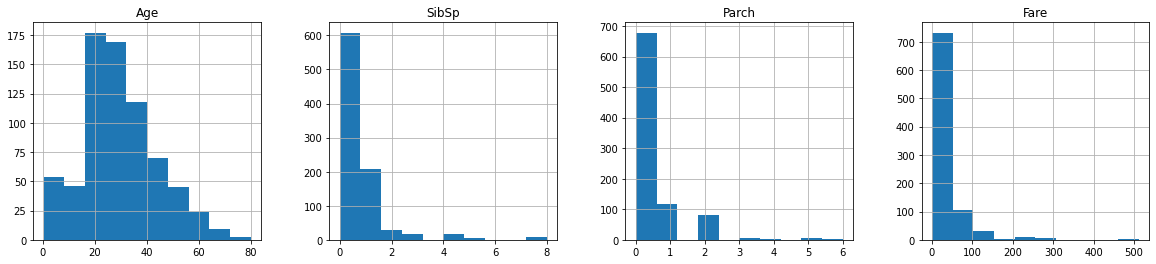

In [8]:
als_hist = histplot.Utils(train_df)
ax_list = als_hist.hist(df_num.columns)

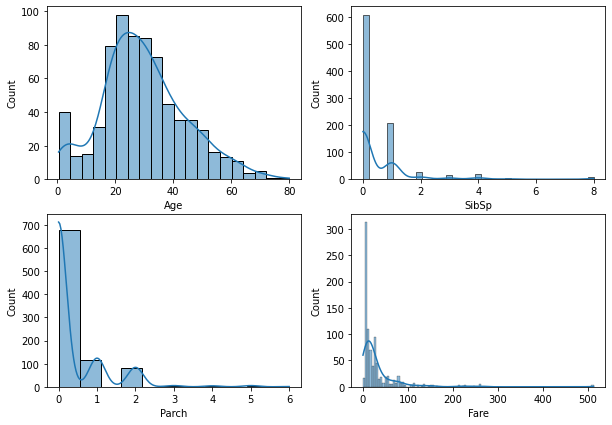

In [9]:
ax_list = als_hist.sns_hist(df_num.columns, col_num=2, figsize=(10, 7))

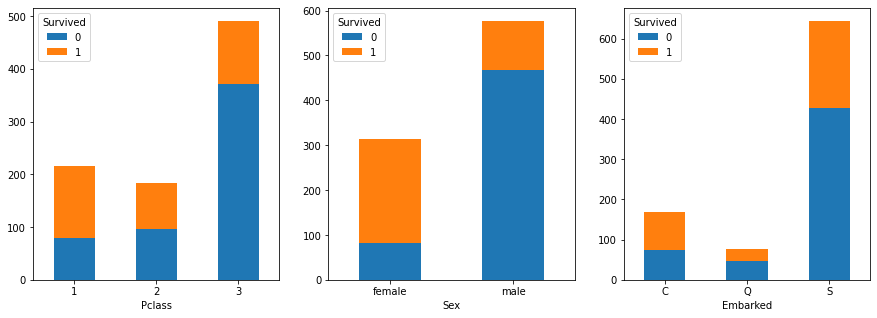

In [10]:
als_bar = barplot.Utils(train_df)
fig, axs = als_bar.stacked_bar('Survived', columns=['Pclass', 'Sex', 'Embarked'], col_num=3, figsize=(15, 5))

In [11]:
# Cabin used as category will be too diverse. Let's use first character of Cabin as feature
train_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [12]:
train_df['Cabin'].fillna('U', inplace=True)
train_df['Cabin_type'] = train_df.Cabin.apply(lambda v: 'U' if v is None else v[0])
train_df['Cabin_type'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_type, dtype: int64

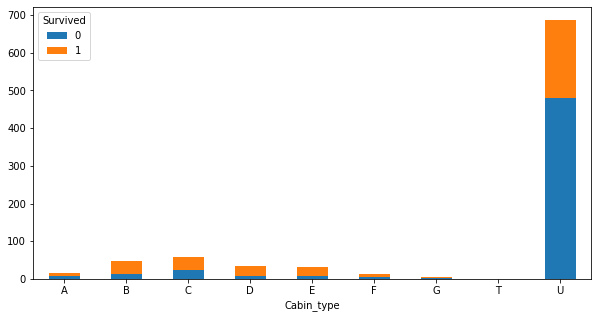

In [13]:
ax = als_bar.stacked_bar('Survived', columns=['Cabin_type'], col_num=2, figsize=(10, 5))

<font color='darkred' size='3ptx'>**Observations**</font>:
* Only `Age` has a somewhat normal distribution. The other values are skewed to the left with longtails to the right.
    * Does age group affect the survival rate? Bin by age group
    * Most of the population is in their late teens to late 30s.
* Most paid a low fare (`Fare`), many are single with no family (`Parch` & `SibSp`)
* Should we normalize these values using a logarithmic method?

<a id='correlation'></a>
#### correlation with `Survived`

In [14]:
# Gender breakdown
print(train_df['Sex'].value_counts())
print()
print(train_df['Sex'].value_counts(normalize=True)) #Percentage breakdown

male      577
female    314
Name: Sex, dtype: int64

male      0.647587
female    0.352413
Name: Sex, dtype: float64


In [15]:
male_s1 = train_df[(train_df['Sex']=='male') & (train_df['Survived']==1)].shape[0]
male_s0 = train_df[(train_df['Sex']=='male') & (train_df['Survived']==0)].shape[0]
print(f"Number of male survial={male_s1}; Number of male not survial={male_s0}; avg = {male_s1/(male_s1+male_s0)}")

Number of male survial=109; Number of male not survial=468; avg = 0.18890814558058924


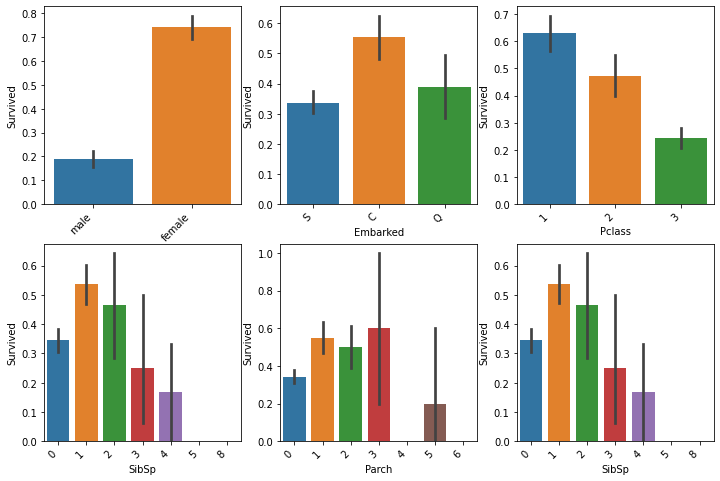

In [16]:
# https://seaborn.pydata.org/generated/seaborn.barplot.html
fig, ax = als_bar.sns_barplot(
    'Survived', 
    ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'SibSp'], 
    col_num=3, 
    figsize=(12, 8)
)

<font color='darkred' size='3ptx'>**Observations**</font>:
* Many more females survived (`Sex`)
* People who embarked from Cherbourg had higher survival rate (`Embarked=C`). Let's explore this further?
* First and second class passangers survived better (`PClass in [1,2]`). Due to location of cabins?
* Smaller families had higher survival rates,best if you had 1 or 2 other people in your family (`SibSp in [1,2]` or `Parch in [1, 2, 3]`).

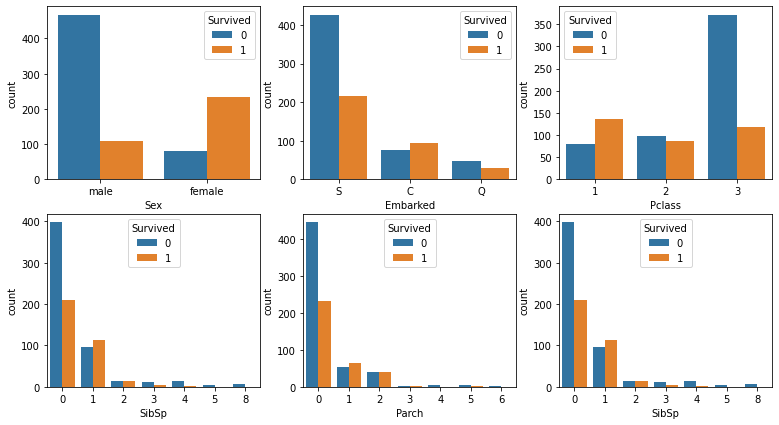

In [17]:
fig, ax = als_bar.sns_countplot(
    'Survived', 
    ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'SibSp'], 
    col_num=3, 
    figsize=(13, 7)
)

<font color='darkred' size='3ptx'>**Observations**</font>:
* People were more chivalrous back in then? Or women were better able to negotiate their way on to life boats? Maybe they were with their children?

<a id='embarked_analysis'></a>
#### `Embarked` analysis

In [18]:
columns = ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']
for column in columns:
    print(pd.pivot_table(train_df, index='Survived', columns=column, values='Name', aggfunc='count'))
    print("========================================================================================")  

Sex       female  male
Survived              
0             81   468
1            233   109
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217
SibSp         0      1     2     3     4    5    8
Survived                                          
0         398.0   97.0  15.0  12.0  15.0  5.0  7.0
1         210.0  112.0  13.0   4.0   3.0  NaN  NaN
Parch         0     1     2    3    4    5    6
Survived                                       
0         445.0  53.0  40.0  2.0  4.0  4.0  1.0
1         233.0  65.0  40.0  3.0  NaN  1.0  NaN


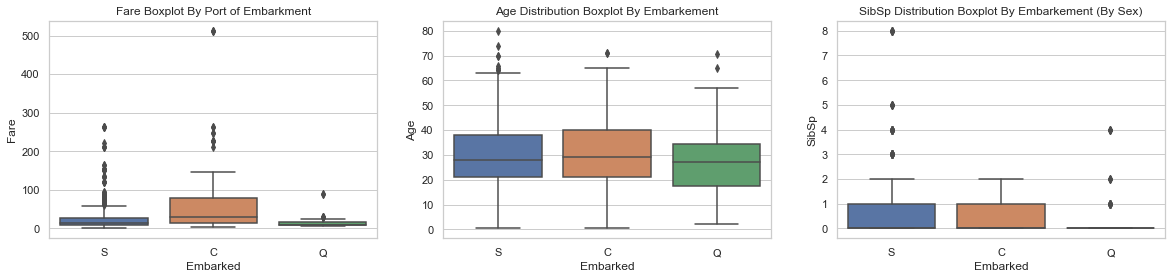

In [19]:
als_box = boxplot.Utils(train_df)
fig, ax = als_box.sns_boxplot(
    'Embarked',
    ['Fare', 'Age', 'SibSp'],
    [
        'Fare Boxplot By Port of Embarkment',
        'Age Distribution Boxplot By Embarkement',
        'SibSp Distribution Boxplot By Embarkement (By Sex)'
    ]
)

<font color='darkred' size='3ptx'>**Observations**</font>:
* People from Cherbourg, France are able to pay more money for fare, and support the hypothesis that **wealther passengers had a higher chance of survival.**
* Fare outliers from Cherbourg dataset may be worthy of analysis
* **Wealth matters. People from 1st class had higher rates of survival**, and more people survived rather than drowned compared to the other classes.
* **You have a higher chance of surviving if you're solo or have 1 family member with you compared to a large family**. Maybe it was difficult to choose which family member would survive? Or maybe it was more expensive to have a 1st class cabin and better location to boats?

<a id='binning_age'></a>
#### binning of `Age`
Let's do binning of `Age` to see if there is any feature in them:

In [20]:
cut_labels = ['>10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
cut_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
cut_df = train_df
cut_df['cut_age'] = pd.cut(cut_df['Age'], cut_bins, labels=cut_labels)
age_bin_df = cut_df.groupby(['cut_age']).mean()
age_bin_df

,Survived,Pclass,Age,SibSp,Parch,Fare
cut_age,,,,,,
>10,0.593750,2.640625,4.268281,1.843750,1.421875,30.434439
11-20,0.382609,2.530435,17.317391,0.591304,0.391304,29.529531
21-30,0.365217,2.386957,25.423913,0.321739,0.239130,28.306719
31-40,0.445161,2.090323,35.051613,0.374194,0.393548,42.496100
41-50,0.383721,1.918605,45.372093,0.372093,0.430233,41.163181
51-60,0.404762,1.523810,54.892857,0.309524,0.309524,44.774802
61-70,0.235294,1.529412,63.882353,0.176471,0.352941,45.910782
71-80,0.200000,1.800000,73.300000,0.000000,0.000000,25.936680


In [21]:
column = 'cut_age'
train_df[[column, 'Survived']].pivot_table(index='Survived', columns=column, aggfunc='size') \
                                  .style.background_gradient()

cut_age,>10,11-20,21-30,31-40,41-50,51-60,61-70,71-80
Survived,,,,,,,,
0,26,71,146,86,53,25,13,4
1,38,44,84,69,33,17,4,1


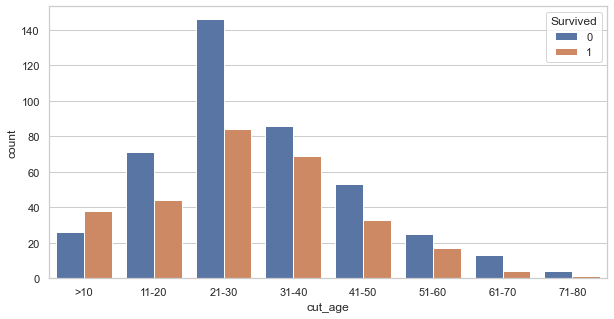

In [22]:
# als_bar = barplot.Utils(train_df)
fig = als_bar.sns_countplot(
    'Survived', 
    'cut_age', 
    figsize=(10, 5)
)

<font color='darkred' size='3ptx'>**Observations**</font>:
* Survival based on `Age` followed a somewhat normal distribution with a tail to the right with older people.
* **Young children and infants survived more than died**. Probably the mentality of women and children to be saved first.
* **High survival rate for people in age 31-40**.

<a id='binning_fare'></a>
#### binning of `Fare`
Let's do binning of `Fare` to see if there is any feature in them：

In [23]:
train_df, test_df = get_data()
print(f"Fare range: {max(train_df.Fare)}~{min(train_df.Fare)}")

Fare range: 512.3292~0.0


In [24]:
cut_labels = ['>100', '100-200', '200-300', '300-400', '400-500', '500-600']
cut_bins = [0, 100, 200, 300, 400, 500, 600]
cut_df = train_df
cut_df['cut_fare'] = pd.cut(cut_df['Fare'], cut_bins, labels=cut_labels)
cut_df['cut_fare'] = cut_df.apply(lambda r: r.cut_fare if r.Fare > 0 else 'unknown', axis=1)

In [25]:
cut_df[cut_df['Fare']==0][['Fare', 'cut_fare'] + list(filter(lambda e: e.startswith('fare_'), train_df.columns))]

,Fare,cut_fare
PassengerId,,
180,0.0,unknown
264,0.0,unknown
272,0.0,unknown
278,0.0,unknown
303,0.0,unknown
414,0.0,unknown
467,0.0,unknown
482,0.0,unknown
598,0.0,unknown


In [26]:
train_df[['Fare', 'cut_fare'] + list(filter(lambda e: e.startswith('fare_'), train_df.columns))].sample(n=15)

,Fare,cut_fare
PassengerId,,
366,7.2500,>100
873,5.0000,>100
149,26.0000,>100
313,26.0000,>100
475,9.8375,>100
745,7.9250,>100
748,13.0000,>100
105,7.9250,>100
27,7.2250,>100


In [27]:
fare_bin_df = cut_df.groupby(['cut_fare']).mean()
fare_bin_df

,Survived,Pclass,Age,SibSp,Parch,Fare
cut_fare,,,,,,
100-200,0.757576,1.000000,32.430667,0.606061,0.787879,131.108200
200-300,0.647059,1.000000,30.333333,0.882353,1.176471,238.187253
500-600,1.000000,1.000000,35.333333,0.000000,0.333333,512.329200
>100,0.366950,2.399757,29.476859,0.523694,0.356015,22.820423
unknown,0.066667,1.933333,35.142857,0.000000,0.000000,0.000000


In [28]:
column = 'cut_fare'
train_df[[column, 'Survived']].pivot_table(index='Survived', columns=column, aggfunc='size') \
                                  .style.background_gradient()

cut_fare,100-200,200-300,500-600,>100,unknown
Survived,,,,,
0,8.000000,6.000000,nan,521.000000,14.000000
1,25.000000,11.000000,3.000000,302.000000,1.000000


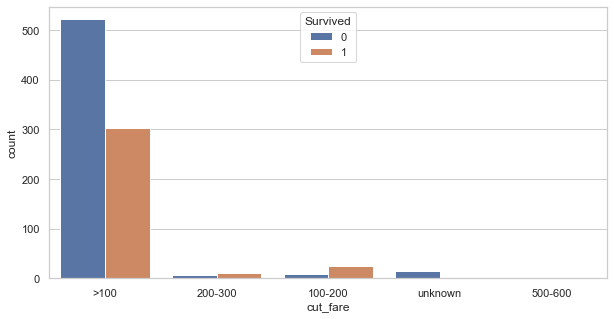

In [29]:
als_bar = barplot.Utils(train_df)
fig = als_bar.sns_countplot(
    'Survived', 
    'cut_fare', 
    figsize=(10, 5)
)

<font color='darkred' size='3ptx'>**Observations**</font>:
* Higher fare, higher survial rate.
* `Fare < 100` has a obvious lowest survival rate compared to other `Fare` binning.

<a id='outlier_analysis'></a>
### <font color='darkgreen'>Outliers Analysis</font>
* [Fare](#outlier_fare)
* [Sibsp](#outlier_sibsp)
* [Ticket numbering](#outlier_ticketnumber)
* [Age](#outlier_age)

<a id='outlier_fare'></a>
#### Fare

<AxesSubplot:title={'center':'Fare outlier Boxplot'}, xlabel='Fare'>

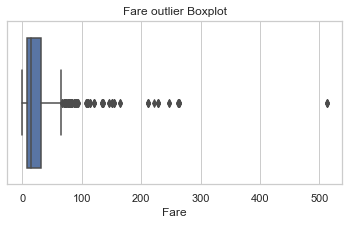

In [30]:
als_box.set_figsize((6, 3))
als_box.s_boxplot("Fare", title='Fare outlier Boxplot')

In [31]:
train_df.loc[train_df['Fare'] > 500]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cut_fare
PassengerId,,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,500-600
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,500-600
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,500-600


<font color='orange' size='3ptx'>**Findings:**</font><br/>
These outliers paid the princely sum of 512 pounds. In today's pound it would be worth a staggering 58,864 pounds! (<font color='brown'>**Note:** each group had both the same ticket number and fare paid</font>). This was by far the most out of any of the guests. Part of the same group lead by the wealthy Mr. Cardeza - Miss. Ward the maid, and Mr. Lesurer the manservant. They were on their way back to the USA by way of Cherbourg, France.
* All similar age
* Multiple cabins but interestly all on the 'B' deck. **Could this be the best deck on the ship? We should analyze deck levels for our model.**
* **Feature:** Cherbourg was the best place to leave if you wanted to survive. We will add this to our list of features for the ML models.
* **Feature:** Maybe is there a correlations between 'PC' tickets and survival rate?

To learn more about this group visit this biography of [Miss. Anna Ward](https://www.encyclopedia-titanica.org/titanic-survivor/annie-moore-ward.html)

<a id='outlier_ticketnumber'></a>
#### Ticket Number Analysis

In [32]:
# Check what kinds of ticket we have
train_df.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [33]:
# The outliers had similar ticket number structures with 'PC'. We find that all tickets with 'PC' had a 65% of survival. 
ticket_pc_df = train_df[train_df['Ticket'].str.match("PC")]
print(ticket_pc_df.describe())

        Survived  Pclass        Age      SibSp      Parch        Fare
count  60.000000    60.0  50.000000  60.000000  60.000000   60.000000
mean    0.650000     1.0  37.120000   0.333333   0.233333  122.080483
std     0.480995     0.0  13.362512   0.572437   0.499717  114.189525
min     0.000000     1.0  16.000000   0.000000   0.000000   25.925000
25%     0.000000     1.0  24.750000   0.000000   0.000000   49.504200
50%     1.000000     1.0  36.000000   0.000000   0.000000   79.200000
75%     1.000000     1.0  47.500000   1.000000   0.000000  148.256225
max     1.000000     1.0  71.000000   2.000000   2.000000  512.329200


In [34]:
# Inspect 1st class ticket structure
pclass_df = train_df.loc[train_df['Pclass'] == 1 & train_df['Ticket'].str.match("PC")]
pclass_df.groupby(['Ticket']).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Ticket,,,,,,
PC 17318,0.000000,1.0,NaN,0.000000,0.000000,25.9250
PC 17473,1.000000,1.0,36.000000,0.000000,0.000000,26.2875
PC 17474,1.000000,1.0,36.000000,0.000000,0.000000,26.3875
PC 17475,1.000000,1.0,35.000000,0.000000,0.000000,26.2875
PC 17476,1.000000,1.0,42.000000,0.000000,0.000000,26.2875
PC 17477,1.000000,1.0,24.000000,0.000000,0.000000,69.3000
PC 17482,1.000000,1.0,24.000000,0.000000,0.000000,49.5042
PC 17483,0.000000,1.0,NaN,0.000000,0.000000,221.7792
PC 17485,1.000000,1.0,39.500000,0.500000,0.000000,56.9292


In [35]:
# Inspect patterns for tickets with Letters in 1st class who survived - 'PC' in all but one
not_numeric_tickets_df = train_df.loc[train_df.Ticket.str.contains('[A-Za-z]')]
tickets_df2 = train_df.copy()
tickets_df2['numeric_ticket'] = train_df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
pd.pivot_table(tickets_df2, index='Survived', columns='numeric_ticket', values='Name', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


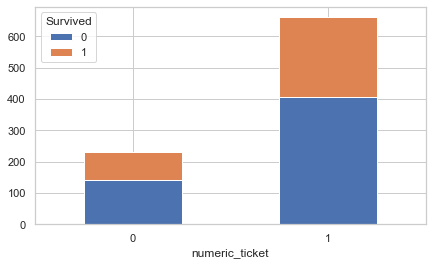

In [36]:
als_bar = barplot.Utils(tickets_df2)
ax = als_bar.stacked_bar('Survived', columns=['numeric_ticket'], figsize=(7, 4))

In [37]:
# Analyze tickets with the letters 'P', 'C', or 'A'
# Again, we find that 'P' has the highest rate in these numbers for survival but lower than 'PC'
letters = ['P', 'C', 'A', 'PC', 'S', 'W']
for letter in letters:
    letter_df = train_df.loc[train_df.Ticket.str.contains(letter)]
    percent = letter_df.Survived.mean()
    count = letter_df.Survived.count()
    print(f'Letter {letter}: {round(percent*100, 1)}% survival rate out of {count} tickets')

Letter P: 58.1% survival rate out of 86 tickets
Letter C: 47.3% survival rate out of 146 tickets
Letter A: 25.6% survival rate out of 82 tickets
Letter PC: 65.0% survival rate out of 60 tickets
Letter S: 31.3% survival rate out of 67 tickets
Letter W: 25.0% survival rate out of 16 tickets


<font color='orange' size='3ptx'>**Findings:**</font><br/>
Tickets with the letter 'PC' had a 65% survival rate. Because of this, we should add this as a feature to our model.

<a id='outlier_sibsp'></a>
#### Sibling or Spouse Outlier Analysis

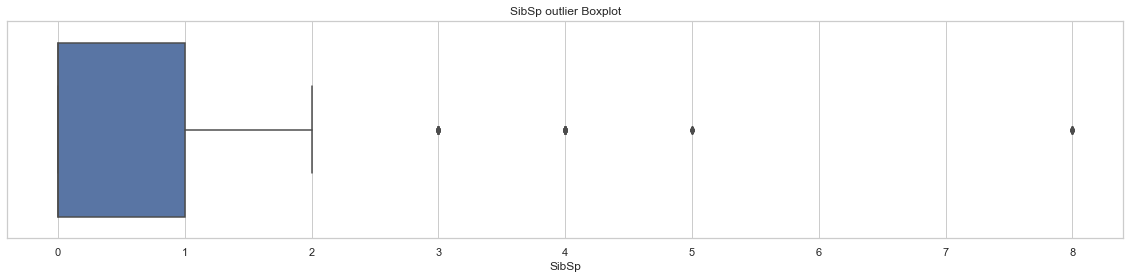

In [38]:
ax = als_box.s_boxplot("SibSp", title='SibSp outlier Boxplot')

In [39]:
# We see that the outliers came from 2 families
family_df = train_df.loc[train_df['SibSp'] > 4]
family_df.sort_values('Name')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cut_fare
PassengerId,,,,,,,,,,,,
481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.90,NaN,S,>100
387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.90,NaN,S,>100
60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,>100
72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.90,NaN,S,>100
684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.90,NaN,S,>100
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,>100
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,>100
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,>100
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,>100


In [40]:
# Survival rates for group size.
# Can we bin people by family or not? Maybe people had a higher survival rate if they had fewer family members?
train_df.groupby(['SibSp'])['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

<font color='orange' size='3ptx'>**Family Size Outlier Findings:**</font><br/>
Unforetunately, the Goodwin and Sage families - who had 5 or more members - did not fare well. They all perished. Maybe it's because of their socio economic status. Maybe it's because there was just too many of them to quickly escape to a life boat. Or maybe it's because of their cabin placement. **Having a large family was tragic in the Titanic**.

<a id='outlier_age'></a>
#### Age Outlier Analysis

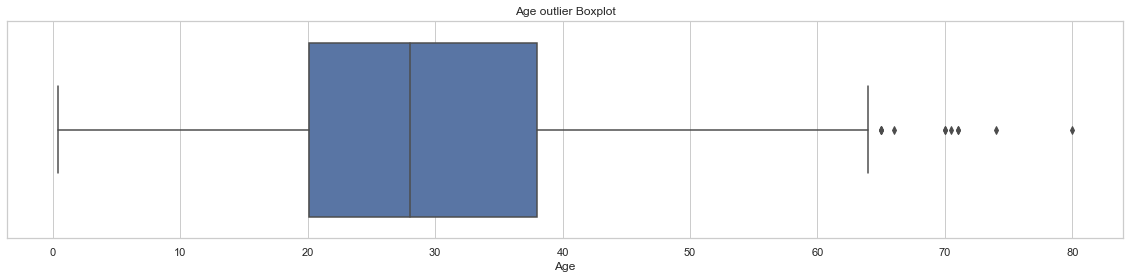

In [41]:
ax = als_box.s_boxplot("Age", title='Age outlier Boxplot')

In [42]:
# Inspect passengers Ages 65 and up
age_df = train_df.loc[train_df['Age'] > 64]
age_df.sort_values('Age', ascending=False)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cut_fare
PassengerId,,,,,,,,,,,,
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,>100
852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,>100
97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,>100
494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,>100
117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,>100
673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S,>100
746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S,>100
34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S,>100
55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,>100


In [43]:
# Name contains `Wilson`
train_df[train_df.Name.str.contains('Wilson')]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cut_fare
PassengerId,,,,,,,,,,,,
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,>100
880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,>100


<font color='orange' size='3ptx'>**Age Outlier Findings:**</font><br/>
**While it doesn't bode well to be elderly on the Titanic, the eldest person `Barkworth` actually survived!** He actually was able to buoy himself on his briefcase and a fur coat until he found an overturned lifeboat. To learn more visit the [biography of Mr. Algernon Barkworth](https://www.encyclopedia-titanica.org/titanic-survivor/algernon-barkworth.html).

<a id='name_analysis'></a>
### <font color='darkgreen'>Name Analysis</font>

<a id='title_analysis'></a>
#### Title
Here I will look if the title of the passenger had any correlation to surving the Titantic - e.g. Mr., Mrs., etc.

In [44]:
title_df = train_df.copy()
title_df['title'] = train_df.Name.apply(lambda x: x.split(',')[1].split(' ')[1].strip())
title_df['title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Jonkheer.      1
the            1
Lady.          1
Mme.           1
Don.           1
Ms.            1
Sir.           1
Capt.          1
Name: title, dtype: int64

In [45]:
pd.pivot_table(title_df, index='Survived', columns='title', values='Name', aggfunc='count')

title,Capt.,Col.,Don.,Dr.,Jonkheer.,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.,the
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


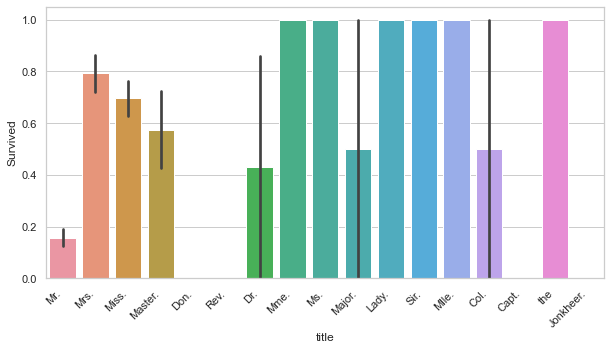

In [46]:
als_bar = barplot.Utils(title_df)
g = als_bar.sns_barplot('Survived', ['title'], figsize=(10, 5))

In [47]:
title_df['count'] = 1
title_df[['title', 'Survived', 'count']].groupby('title').agg({'count':'size', 'Survived':'mean'}). \
        reset_index().sort_values(['Survived', 'count'], ascending=[False, False])

,title,count,Survived
9,Mlle.,2,1.000000
5,Lady.,1,1.000000
10,Mme.,1,1.000000
13,Ms.,1,1.000000
15,Sir.,1,1.000000
16,the,1,1.000000
12,Mrs.,125,0.792000
8,Miss.,182,0.697802
7,Master.,40,0.575000
1,Col.,2,0.500000


<font color='orange' size='3ptx'>**Title Findings:**</font><br/>
* Titles were a fairly good predictor if you survived the Titanic
* **Female titles are the good indicators** (Mrs., Miss., Lady etc.)

<a id='name_token_analysis'></a>
#### Name token analysis
Let's dive in more deep to see the token generated by `Name` to see if there is any feature out there

In [48]:
from collections import defaultdict

title_df = train_df.copy()
tf_dict = defaultdict(int) # Key as token, value as frequency
for name in train_df.Name.unique():
    for token in name.split():
        if token.startswith('('):
            token = token[1:]
        token = token.lower()
        tf_dict[token] += 1
        
# Remove token with frequency less than lower_frequency_bound
lower_frequency_bound = 4
token_items = sorted(list(filter(lambda t: t[1] > lower_frequency_bound and len(t[0]) > 1, tf_dict.items())), key=lambda t: t[1], reverse=True)

In [49]:
print(f"{len(token_items)}")
token_items[:20]

70


[('mr.', 517),
 ('miss.', 182),
 ('mrs.', 125),
 ('william', 62),
 ('john', 44),
 ('master.', 40),
 ('henry', 33),
 ('james', 24),
 ('charles', 23),
 ('george', 22),
 ('thomas', 21),
 ('edward', 18),
 ('mary', 17),
 ('joseph', 16),
 ('anna', 16),
 ('elizabeth', 15),
 ('johan', 15),
 ('frederick', 15),
 ('richard', 13),
 ('samuel', 13)]

In [50]:
# Generate column `name_token_<token>` for analysis
def is_token_exist(name, t):
    tokens = list(map(lambda t: t[1:] if t.startswith('(') else t, str(name.lower()).split()))
    return 1 if t in tokens else 0

for t in token_items:
    title_df[f'name_token_{t[0]}'] = train_df.Name.apply(lambda x: is_token_exist(str(x), t[0]))

In [51]:
title_df[['Name'] + list(filter(lambda t: t.startswith('name_token'), title_df.columns))].head()

,Name,name_token_mr.,name_token_miss.,name_token_mrs.,name_token_william,name_token_john,name_token_master.,name_token_henry,name_token_james,name_token_charles,...,name_token_ada,name_token_gustaf,name_token_walter,name_token_patrick,name_token_august,name_token_harry,name_token_ernst,name_token_nils,name_token_kate,name_token_louise
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Heikkinen, Miss. Laina",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Allen, Mr. William Henry",1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
corr_df = corr(title_df[['Survived'] + list(filter(lambda t: t.startswith('name_token'), title_df.columns))], 'Survived')

In [53]:
corr_df

,feature,target,corr
74,name_token_mr.,Survived,0.549199
82,name_token_mrs.,Survived,0.339040
83,name_token_miss.,Survived,0.327093
186,name_token_elizabeth,Survived,0.129917
247,name_token_mary,Survived,0.109225
267,name_token_marie,Survived,0.104322
299,name_token_alice,Survived,0.096132
305,name_token_anne,Survived,0.095179
307,name_token_bertha,Survived,0.095179
310,name_token_ada,Survived,0.095179


In [54]:
name_token_features = list(map(lambda t: t[11:], list(corr_df.feature.unique())))
name_token_features

['mr.',
 'mrs.',
 'miss.',
 'elizabeth',
 'mary',
 'marie',
 'alice',
 'anne',
 'bertha',
 'ada',
 'florence',
 'margaret',
 'master.',
 'kate',
 'anna',
 'edith',
 'alfred',
 'sage,',
 'johan',
 'goodwin,']

<font color='orange' size='3ptx'>**Title Findings:**</font><br/>
* Same as analysis from title. `mr.`, `mrs.` and `miss.` are high correlated with target `Survived`.

<a id='sect4'></a>
## <font color='darkblue'>4. Preprocessing Data</font>
([Back](#sect0)) <font size='3ptx'>**The training and test datasets don't have the same attributes after feature engineering. Therefore, I had to be careful about choosing with features to leave in the datasets.**</font>
* <font size='3ptx'>[**Feature engineering**](#sect4_1)</font>

<a id='sect4_1'></a>
### <font color='darkgreen'>Feature engineering:</font>
* **Ticket lettering** - with 'P' have a 58% chance of survival -> refer to above code
* [**Pclass**](#pclass_features) Include 1st and 2nd class. Drop 3rd class?
* [**Sex**](#sex_features): Female are more likely to survive than male
* [**Embarked**](#embarked_features): `Embarked=S` seems to have less likelihood to survive.
* [**Age imputation for continuous data**](#age_features) - use mean/median fillna()
* [**Fare scaling/normalization for ML optimization**](#fare_features). Gaussian calculations do not like large variance in values: [article1](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/), [article2](https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler)
* [**Family size `SibSp` binning two groups of 1-3, >3**](#sibsp_features)
* [**Parch**](#parch_features): 
* [**Name title segregation** - split/strip titles out names: source](#name_title_segregation)
* **One Hot Encoding** - categorial data must me turned into numerical with [One Hot Encoding or Get Dummies](https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970)

In [55]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [56]:
train_df, test_df = get_data()

# Inspect the column shape and NaN values
print('Test Data', test_df.info())
print()
print('Train Data', train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
Test Data None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   A

<a id='name_title_segregation'></a>
#### Name title segregation

In [57]:
# Feature of Title
def gen_title_feature(
    train_df, 
    test_df, 
    interested_title_list=['Mrs.', 'Miss.', 'Ms.', 'Mme.', 'Lady.', 'Master.', 'Rev.', 'Mlle.'],
    drop_title=True):
    # name titles
    for df in [train_df, test_df]:
        df['title'] = df.Name.apply(lambda x: x.split(',')[1].split(' ')[1].strip())
        df['title'] = df.title.apply(lambda t: t if t in interested_title_list else 'Others')
        
    for df in [train_df, test_df]:
        for title_name in interested_title_list + ['Others']:
            df['title_'+title_name] = df.title.apply(lambda t: 1 if t == title_name else 0)
            
    # name token
    for df in [train_df, test_df]:
        for t in name_token_features:
            df[f'name_token_{t}'] = df.Name.apply(lambda x: is_token_exist(str(x), t))
            
    if drop_title:
        for df in [train_df, test_df]:
            df.drop(columns=['title'], inplace=True)
        
    return train_df, test_df

In [58]:
train_df, test_df = get_data()
train_df, test_df = gen_title_feature(train_df, test_df)
test_df[['Name'] + list(filter(lambda c: c.startswith('title'), train_df.columns))].head()

,Name,title_Mrs.,title_Miss.,title_Ms.,title_Mme.,title_Lady.,title_Master.,title_Rev.,title_Mlle.,title_Others
PassengerId,,,,,,,,,,
892,"Kelly, Mr. James",0,0,0,0,0,0,0,0,1
893,"Wilkes, Mrs. James (Ellen Needs)",1,0,0,0,0,0,0,0,0
894,"Myles, Mr. Thomas Francis",0,0,0,0,0,0,0,0,1
895,"Wirz, Mr. Albert",0,0,0,0,0,0,0,0,1
896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,0,0,0,0,0,0,0,0


In [59]:
test_df[['Name'] + list(filter(lambda c: c.startswith('name_token'), train_df.columns))].head()

,Name,name_token_mr.,name_token_mrs.,name_token_miss.,name_token_elizabeth,name_token_mary,name_token_marie,name_token_alice,name_token_anne,name_token_bertha,...,name_token_florence,name_token_margaret,name_token_master.,name_token_kate,name_token_anna,name_token_edith,name_token_alfred,"name_token_sage,",name_token_johan,"name_token_goodwin,"
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,"Kelly, Mr. James",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
893,"Wilkes, Mrs. James (Ellen Needs)",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
894,"Myles, Mr. Thomas Francis",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895,"Wirz, Mr. Albert",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='age_features'></a>
#### Age imputation for continuous data

In [60]:
# Features of Age (imputation w/ median to acccount for outliers)
def gen_age_feature(
        train_df,
        test_df,
        cut_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80],
        cut_labels = ['>10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80'],
        drop_cut_age=True,        
    ):
    train_df.Age.fillna(train_df.Age.median(), inplace=True)
    test_df.Age.fillna(test_df.Age.median(), inplace=True)
    
    # age binning
    for df in [train_df, test_df]:
        df['cut_age'] = pd.cut(df['Age'], cut_bins, labels=cut_labels)
        for age_label in cut_labels:
            df['age_'+age_label] = df['cut_age'].apply(lambda a: 1 if a == age_label else 0)
            
    if drop_cut_age:
        for df in [train_df, test_df]:
            df.drop(columns=['cut_age'], inplace=True)
            
    # age normalized
    scaler = MinMaxScaler()
    scaler.fit(train_df[['Age']])
    for df in [train_df, test_df]:
        df['age_norm'] = scaler.transform(df[['Age']])
        
    return train_df, test_df

In [61]:
train_df, test_df = gen_age_feature(train_df, test_df)
train_df[['Age'] + list(filter(lambda c: c.startswith('age'), train_df.columns))].head()

,Age,age_>10,age_11-20,age_21-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_norm
PassengerId,,,,,,,,,,
1,22.0,0,0,1,0,0,0,0,0,0.271174
2,38.0,0,0,0,1,0,0,0,0,0.472229
3,26.0,0,0,1,0,0,0,0,0,0.321438
4,35.0,0,0,0,1,0,0,0,0,0.434531
5,35.0,0,0,0,1,0,0,0,0,0.434531


<a id='fare_features'></a>
#### Fare scaling/normalization for ML optimization

In [62]:
sorted(train_df.Fare.unique())

[0.0,
 4.0125,
 5.0,
 6.2375,
 6.4375,
 6.45,
 6.4958,
 6.75,
 6.8583,
 6.95,
 6.975,
 7.0458,
 7.05,
 7.0542,
 7.125,
 7.1417,
 7.225,
 7.2292,
 7.25,
 7.3125,
 7.4958,
 7.5208,
 7.55,
 7.6292,
 7.65,
 7.725,
 7.7292,
 7.7333,
 7.7375,
 7.7417,
 7.75,
 7.775,
 7.7875,
 7.7958,
 7.8,
 7.8292,
 7.8542,
 7.875,
 7.8792,
 7.8875,
 7.8958,
 7.925,
 8.0292,
 8.05,
 8.1125,
 8.1375,
 8.1583,
 8.3,
 8.3625,
 8.4042,
 8.4333,
 8.4583,
 8.5167,
 8.6542,
 8.6625,
 8.6833,
 8.7125,
 8.85,
 9.0,
 9.2167,
 9.225,
 9.35,
 9.475,
 9.4833,
 9.5,
 9.5875,
 9.825,
 9.8375,
 9.8417,
 9.8458,
 10.1708,
 10.4625,
 10.5,
 10.5167,
 11.1333,
 11.2417,
 11.5,
 12.0,
 12.275,
 12.2875,
 12.35,
 12.475,
 12.525,
 12.65,
 12.875,
 13.0,
 13.4167,
 13.5,
 13.7917,
 13.8583,
 13.8625,
 14.0,
 14.1083,
 14.4,
 14.4542,
 14.4583,
 14.5,
 15.0,
 15.0458,
 15.05,
 15.1,
 15.2458,
 15.5,
 15.55,
 15.7417,
 15.75,
 15.85,
 15.9,
 16.0,
 16.1,
 16.7,
 17.4,
 17.8,
 18.0,
 18.75,
 18.7875,
 19.2583,
 19.5,
 19.9667,
 20.2

In [63]:
# Features of Fare (imputation w/ median to acccount for outliers)
def gen_fare_feature(
        train_df,
        test_df,
        cut_labels = ['100', '100-200', '200-300', '300-400', '400-500', '500-600'],
        cut_bins = [0, 100, 200, 300, 400, 500, 600],
        drop_cut_fare=True
    ):
    train_df.Fare.fillna(train_df.Fare.median(), inplace=True)
    test_df.Fare.fillna(test_df.Fare.median(), inplace=True)
    
    # fare binning    
    for df in [train_df, test_df]:
        df['cut_fare'] = pd.cut(df['Fare'], cut_bins, labels=cut_labels)
        df['cut_fare'] = df.apply(lambda r: r.cut_fare if r.Fare > 0 else 'unknown', axis=1)
        for cut_label in cut_labels + ['unknown']:
            df['fare_'+cut_label] = df['cut_fare'].apply(lambda a: 1 if a == cut_label else 0)
    
    # fare normalization
    scaler = MinMaxScaler()
    scaler.fit(train_df[['Fare']])
    for df in [train_df, test_df]:
        df['fare_norm'] = scaler.transform(df[['Fare']])
        
    if drop_cut_fare:
        for df in [train_df, test_df]:
            df.drop(columns=['cut_fare'], inplace=True)
            
    return train_df, test_df

In [64]:
train_df, test_df = gen_fare_feature(train_df, test_df)
test_df[
    ['Fare', 'fare_norm'] + list(filter(lambda e: e.startswith('fare_'), test_df.columns))
].sort_values('Fare', ascending=False)

,Fare,fare_norm,fare_100,fare_100-200,fare_200-300,fare_300-400,fare_400-500,fare_500-600,fare_unknown,fare_norm
PassengerId,,,,,,,,,,
1235,512.3292,1.000000,0,0,0,0,0,1,0,1.000000
945,263.0000,0.513342,0,0,1,0,0,0,0,0.513342
961,263.0000,0.513342,0,0,1,0,0,0,0,0.513342
916,262.3750,0.512122,0,0,1,0,0,0,0,0.512122
1034,262.3750,0.512122,0,0,1,0,0,0,0,0.512122
...,...,...,...,...,...,...,...,...,...,...
1008,6.4375,0.012565,1,0,0,0,0,0,0,0.012565
1025,6.4375,0.012565,1,0,0,0,0,0,0,0.012565
913,3.1708,0.006189,1,0,0,0,0,0,0,0.006189


<a id='pclass_features'></a>
#### Pclass features

In [65]:
def gen_pclass_feature(
        train_df,
        test_df
    ):
    for df in [train_df, test_df]:
        for pc_v in df.Pclass.unique():
            df[f'pc_{pc_v}'] = df.Pclass.apply(lambda v: 1 if v == pc_v else 0)
    
    return train_df, test_df

In [66]:
train_df, test_df = gen_pclass_feature(train_df, test_df)
train_df[['Pclass'] + list(filter(lambda c: c.startswith('pc_'), train_df.columns))].head()

,Pclass,pc_3,pc_1,pc_2
PassengerId,,,,
1,3,1,0,0
2,1,0,1,0
3,3,1,0,0
4,1,0,1,0
5,3,1,0,0


<a id='sex_features'></a>
#### Sex features

In [67]:
def gen_sex_feature(
        train_df,
        test_df
    ):
    for df in [train_df, test_df]:
        for sex_v in df.Sex.unique():
            df[f'Sex_{sex_v}'] = df.Sex.apply(lambda v: 1 if v == sex_v else 0)
            
    return train_df, test_df

In [68]:
train_df, test_df = gen_sex_feature(train_df, test_df)
train_df[list(filter(lambda c: c.startswith('Sex'), train_df.columns))].head()

,Sex,Sex_male,Sex_female
PassengerId,,,
1,male,1,0
2,female,0,1
3,female,0,1
4,female,0,1
5,male,1,0


<a id='embarked_features'></a>
#### Embarked features

In [69]:
def gen_embarked_feature(
        train_df,
        test_df
    ):
    for df in [train_df, test_df]:
        for embarked_v in ['S', 'C', 'Q']:
            df[f'Embarked_{embarked_v}'] = df.Embarked.apply(lambda v: 1 if v == embarked_v else 0)
            
    return train_df, test_df

In [70]:
train_df, test_df = gen_embarked_feature(train_df, test_df)
train_df[list(filter(lambda c: c.startswith('Embarked'), train_df.columns))].head()

,Embarked,Embarked_S,Embarked_C,Embarked_Q
PassengerId,,,,
1,S,1,0,0
2,C,0,1,0
3,S,1,0,0
4,S,1,0,0
5,S,1,0,0


<a id='sibsp_features'></a>
#### Sibsp features

In [71]:
def gen_sibsp_feature(
        train_df,
        test_df,
        outlier_ulimit=6,
    ):
    for df in [train_df, test_df]:
        df['SibSp_outlier'] = df.SibSp.apply(lambda s: 1 if s >= outlier_ulimit else 0)
        for ss_v in range(outlier_ulimit):
            df[f'SibSp_{ss_v}'] = df.SibSp.apply(lambda v: 1 if v == ss_v else 0)
            
    return train_df, test_df

In [72]:
train_df, test_df = gen_sibsp_feature(train_df, test_df)
train_df[list(filter(lambda c: c.startswith('SibSp'), train_df.columns))].sort_values('SibSp', ascending=False).head(n=20)

,SibSp,SibSp_outlier,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5
PassengerId,,,,,,,,
160,8,1,0,0,0,0,0,0
181,8,1,0,0,0,0,0,0
202,8,1,0,0,0,0,0,0
793,8,1,0,0,0,0,0,0
847,8,1,0,0,0,0,0,0
864,8,1,0,0,0,0,0,0
325,8,1,0,0,0,0,0,0
60,5,0,0,0,0,0,0,1
72,5,0,0,0,0,0,0,1


<a id='parch_features'></a>
#### Parch features

In [73]:
def gen_parch_feature(
        train_df,
        test_df,
        outlier_ulimit=7,
    ):
    for df in [train_df, test_df]:
        df['Parch_outlier'] = df.Parch.apply(lambda s: 1 if s >= outlier_ulimit else 0)
        for pv in range(outlier_ulimit):
            df[f'Parch_{pv}'] = df.Parch.apply(lambda v: 1 if v == pv else 0)
            
    return train_df, test_df

In [74]:
train_df, test_df = gen_parch_feature(train_df, test_df)
train_df[list(filter(lambda c: c.startswith('Parch'), train_df.columns))].sort_values('Parch', ascending=False).head(n=20)

,Parch,Parch_outlier,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
PassengerId,,,,,,,,,
679,6,0,0,0,0,0,0,0,1
639,5,0,0,0,0,0,0,1,0
886,5,0,0,0,0,0,0,1,0
611,5,0,0,0,0,0,0,1,0
26,5,0,0,0,0,0,0,1,0
14,5,0,0,0,0,0,0,1,0
439,4,0,0,0,0,0,1,0,0
361,4,0,0,0,0,0,1,0,0
168,4,0,0,0,0,0,1,0,0


### <font color='darkgreen'>Create the X_train, X_test, and y_train Datasets</font>
Let's drop columns which won't be used as features:

In [75]:
# Create the training and test datasets
unwanted_columns = ['Fare', 'Name', 'Sex', 'Ticket', 'Cabin', 'SibSp', 'Pclass', 'Embarked', 'Age', 'Parch']
X_train_df = train_df.drop(columns=['Survived']).drop(columns=unwanted_columns)
X_test_df = test_df.drop(columns=unwanted_columns)
y_train_df = train_df['Survived']

In [76]:
print(f'y_train_df.shape: {y_train_df.shape}')
print(f'X_train_df.shape: {X_train_df.shape}')
print(f'X_test_df.shape: {X_test_df.shape}')
print('X_train_df Columns:', X_train_df.columns)
print('X_test_df Columns:', X_test_df.columns)

y_train_df.shape: (891,)
X_train_df.shape: (891, 69)
X_test_df.shape: (418, 69)
X_train_df Columns: Index(['title_Mrs.', 'title_Miss.', 'title_Ms.', 'title_Mme.', 'title_Lady.',
       'title_Master.', 'title_Rev.', 'title_Mlle.', 'title_Others',
       'name_token_mr.', 'name_token_mrs.', 'name_token_miss.',
       'name_token_elizabeth', 'name_token_mary', 'name_token_marie',
       'name_token_alice', 'name_token_anne', 'name_token_bertha',
       'name_token_ada', 'name_token_florence', 'name_token_margaret',
       'name_token_master.', 'name_token_kate', 'name_token_anna',
       'name_token_edith', 'name_token_alfred', 'name_token_sage,',
       'name_token_johan', 'name_token_goodwin,', 'age_>10', 'age_11-20',
       'age_21-30', 'age_31-40', 'age_41-50', 'age_51-60', 'age_61-70',
       'age_71-80', 'age_norm', 'fare_100', 'fare_100-200', 'fare_200-300',
       'fare_300-400', 'fare_400-500', 'fare_500-600', 'fare_unknown',
       'fare_norm', 'pc_3', 'pc_1', 'pc_2', 'Sex_male

In [77]:
X_train_df.head()

,title_Mrs.,title_Miss.,title_Ms.,title_Mme.,title_Lady.,title_Master.,title_Rev.,title_Mlle.,title_Others,name_token_mr.,...,SibSp_4,SibSp_5,Parch_outlier,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0


<a id='sect5'></a>
## <font color='darkblue'>5. Train Model</font>
([Back](#sect0)) <font size='3ptx'>**Using 'Cross Validation' to find the average scores for each alogrithm. This will help to prevent overfitting.**</font>
* [sklearn cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [Plotting the confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix)
* [Precision and Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

Below different ML models will be used as baseline for prediction accuracy:
* [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [K Nearest Neighbor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* Naive Bayes
* [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier 

In [79]:
# create function to output scores for each model
def clf_scoring(clf, X_train=X_train_df, y_train=y_train_df):
    clf = clf.fit(X_train, y_train)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5)
    clf_id = clf.__class__.__name__
    print(f'Model: {clf}')
    print('single pass score:', clf.score(X_train, y_train))
    print('k-fold scores:', cv_score)
    print(f'cross-validated score: {cv_score.mean()} std+/- {cv_score.std()}')
    print()
    return dict({
        'singe pass': clf.score(X_train, y_train), 
        'score roc_auc': cv_score.mean(), 
        'std': cv_score.std(), 
        'id': clf_id, 
        'model': clf, 
        'params': clf.get_params()
    })

In [80]:
clfs = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(), 
    GaussianNB(),
    SVC(),
    GradientBoostingClassifier(),
] # XGBClassifier() funny error, will wait to do it later
clf_outputs = []
for model in clfs:
    clf_outputs.append(clf_scoring(model))

Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
single pass score: 0.9865319865319865
k-fold scores: [0.75977654 0.76404494 0.80337079 0.75842697 0.78089888]
cross-validated score: 0.7733036218693113 std+/- 0.017039614581480865

Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min

In [81]:
clf_df = pd.DataFrame(clf_outputs)
clf_df = clf_df.sort_values('score roc_auc', ascending=False).reset_index()
clf_df

,index,singe pass,score roc_auc,std,id,model,params
0,5,0.892256,0.832766,0.013074,GradientBoostingClassifier,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
1,4,0.851852,0.827155,0.028546,SVC,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'C': 1.0, 'break_ties': False, 'cache_size': ..."
2,1,0.986532,0.812592,0.029701,RandomForestClassifier,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,2,0.865320,0.811449,0.032669,KNeighborsClassifier,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
4,0,0.986532,0.773304,0.017040,DecisionTreeClassifier,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
5,3,0.719416,0.724970,0.032571,GaussianNB,"GaussianNB(priors=None, var_smoothing=1e-09)","{'priors': None, 'var_smoothing': 1e-09}"


In [82]:
clf_df.loc[0, 'model']

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [83]:
# Best baseline model for submission
params = clf_df.loc[0].params
clf = GradientBoostingClassifier(**params).fit(X_train_df, y_train_df)

XGBoost Model
Precision score: %89.13
Recall score: %82.0
F1 score: %85.42

Confusion Matrix <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x00000239E0392BE0>


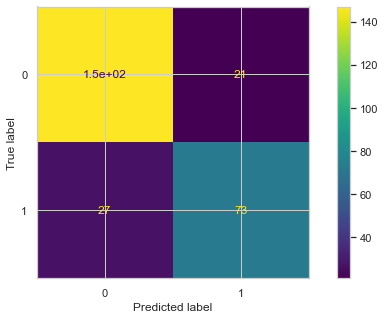

In [84]:
# Confusion Matrix
cm_X_train_df, cm_X_test_df, cm_y_train_df, cm_y_test_df = train_test_split(
    X_train_df, 
    y_train_df, 
    train_size=.7, 
    random_state=0
)

clf_cm = GradientBoostingClassifier(**params).fit(cm_X_train_df, cm_y_train_df)
cm_y_hat_df = clf.predict(cm_X_test_df)

precision = round(precision_score(cm_y_test_df, cm_y_hat_df, average='binary')*100, 2)
recall = round(recall_score(cm_y_test_df, cm_y_hat_df, average='binary')*100, 2)
f1 = round(f1_score(cm_y_test_df, cm_y_hat_df, average='binary')*100, 2)

print('XGBoost Model')
print(f'Precision score: %{precision}')
print(f'Recall score: %{recall}')
print(f'F1 score: %{f1}')
print('')
print(f'Confusion Matrix {plot_confusion_matrix(clf_cm, cm_X_test_df, cm_y_test_df)}')  

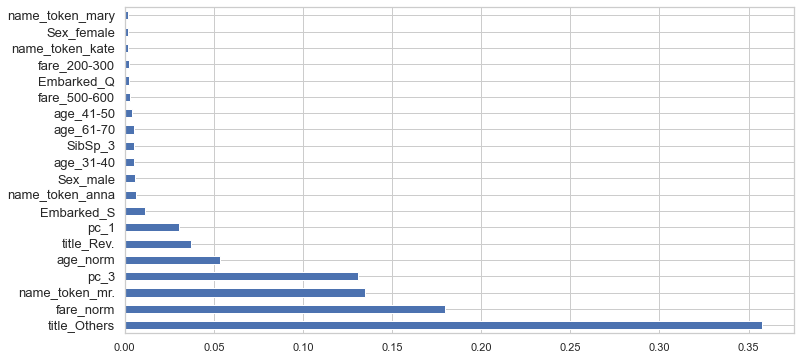

In [85]:
# Feature importance
als_fi = fiplot.Utils(X_train_df)
a = als_fi.treelike_fi(clf, figsize=[12, 6], ytick_fontsize=13)

<a id='sect6'></a>
## <font color='darkblue'>6. Evaluate -> Tune -> Ensemble</font>
([Back](#sect0)) **We can still improve the model by below actions**:
* [**Gridsearch**](#gridsearch): Look for optimal hyperparameters.
* RandomizedSearchCV
* [**Ensembles**](#ensembles) - hard and soft voting: sklearn ensemble overview, VotingClassifier

<a id='gridsearch'></a>
### <font color='darkgreen'>Gridsearch</font>
Here we will use [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from scikit-learn to look for optimial hyperparameters.

In [86]:
# Used later in ensembling methods
estimators = []

In [87]:
def frange(start, end, step):
    while start <= end:
        yield start
        start += step

#### XGBoost
* <font color='violet'>**learning_rate**</font>: usually between 0.1 and 0.01. If you’re focused on performance and have time in front of you, decrease incrementally the learning rate while increasing the number of trees.
* <font color='violet'>**subsample**</font>, which is for each tree the % of rows taken to build the tree. I recommend not taking out too many rows, as performance will drop a lot. Take values from 0.8 to 1.
* Optimize <font color='violet'>**max_depth**</font> parameter. It represents the depth of each tree, which is the maximum number of different features used in each tree. I recommend going from a low `max_depth` (<font color='brown'>3 for instance</font>) and then increasing it incrementally by 1, and stopping when there’s no performance gain of increasing it. This will help simplify your model and avoid overfitting
* <font color='violet'>**gamma**</font>: usually misunderstood parameter, it acts as a regularization parameter. Either 0, 1 or 5.

In [88]:
xb_param_grid = {
    "learning_rate" : list(frange(0.01,0.1,0.02)),
    "max_depth": range(3,10,1),
    # "gamma": [0, 1, 5],
    "subsample": list(frange(0.8, 1, 0.1))
}

In [89]:
clf = GridSearchCV(
    GradientBoostingClassifier(), 
    param_grid=xb_param_grid, 
    cv = StratifiedKFold(n_splits = 10), 
    scoring = "accuracy", 
    n_jobs = -1,
    verbose = 1
)

In [90]:
%%time
clf.fit(X_train_df,y_train_df)

Fitting 10 folds for each of 105 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:  3.4min finished


Wall time: 3min 22s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=...
                                                  presort='deprecated',
                                                  random_state=None,
              

In [91]:
clf.best_score_

0.847390761548065

In [92]:
clf.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [93]:
estimators.append(('xgb', clf))

#### SVC
* <font color='violet'>**Kernels**</font>: The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. It is mostly useful in non-linear separation problem.
* <font color='violet'>**C**</font> (<font color='brown'>Regularisation</font>): <font color='violet'>**C**</font> is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimisation how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. When <font color='violet'>**C**</font> is high it will classify all the data points correctly, also there is a chance to overfit.
* <font color='violet'>**Gamma**</font>: It defines how far influences the calculation of plausible line of separation. When gamma is higher, nearby points will have high influence; low gamma means far away points also be considered to get the decision boundary.

In [94]:
# Set the parameters by cross-validation
tuned_parameters = [
    {
        'kernel': ['rbf'], 
        'gamma': [1e-3, 1e-4],
        'C': [1, 10, 100, 1000]
    },
    {
        'kernel': ['linear'], 
        'C': [1, 10, 100, 1000]
    }
]

In [95]:
clf = GridSearchCV(
    SVC(), 
    tuned_parameters, 
    cv = StratifiedKFold(n_splits = 10), 
    scoring = "accuracy", 
    n_jobs = -1,
    verbose = 1
)

In [ ]:
clf.fit(X_train_df,y_train_df)

In [ ]:
clf.best_score_

In [ ]:
clf.best_estimator_

In [ ]:
estimators.append(('svc', clf))

#### KNeighborsClassifier	

In [ ]:
knc_param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'chebyshev']
}

In [ ]:
clf = GridSearchCV(
    KNeighborsClassifier(), 
    knc_param_grid, 
    cv = StratifiedKFold(n_splits = 10), 
    scoring = "accuracy", 
    n_jobs = -1,
    verbose = 1
)

In [ ]:
clf.fit(X_train_df,y_train_df)

In [ ]:
clf.best_score_

In [ ]:
clf.best_estimator_

In [ ]:
estimators.append(('knn', clf))

In [ ]:
estimators

<a id='ensembles'></a>
### <font color='darkgreen'>Ensembles</font>
Here we will leverage [**VotingClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) from scikit-learn to conduct ensembling:

In [ ]:
eclf1 = VotingClassifier(estimators)

In [ ]:
eclf1 = eclf1.fit(X_train_df,y_train_df)

<a id='sect7'></a>
## <font color='darkblue'>7. Conclusion</font>
([Back](#sect0)) We will submit our result here with below actions:
* Wrap up the work and generate the output with format required by Kaggle
* Submissions with different names

In [ ]:
# Predict the outcomes for the test dataset
y_hat_df = eclf1.predict(X_test_df)

In [ ]:
from datetime import datetime

# prepare submission
submission_tree = pd.DataFrame({'PassengerID': X_test_df.index, 'Survived': y_hat_df})
submission_tree.to_csv(f'JohnLee_submission_ensemble_{datetime.today().strftime("%Y%m%d%H%M%S")}.csv', index=False)
submission_tree.head(n=10)

Now you can go to [this link](https://www.kaggle.com/c/titanic/submit) and upload/submit `JohnLee_submission.csv`.

## <font color='darkblue'>Supplement</font>
* [Improve_Your_Analytics_Projects_With_These_Data_Distributions_Visualizations](https://github.com/johnklee/ml_articles/tree/master/medium/Improve_Your_Analytics_Projects_With_These_Data_Distributions_Visualizations)
* [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)
* [Fine-tuning XGBoost in Python like a boss](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)
* [SVM Parameter Tuning](https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c)
* [SVM Hyperparameter Tuning using GridSearchCV](https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/)
* [k-Neighbors Classifier with GridSearchCV Basics](https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657)